Before you start, hit "Restart & Run All"

In [33]:
%pip install numpy plotly ipywidgets ipython pandas seaborn ipykernel scipy


[notice] A new release of pip is available: 23.0 -> 23.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly.express as px
from ipywidgets import FloatText, VBox, HBox, interactive_output, widgets, FloatSlider, interactive
from IPython.display import display, HTML
import scipy as sp
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

# The First Blog Post You Should Read about Gaussian Processes (With Interactive Plots) 

Is this the 10th blog post you've read about Gaussian Processes and still don't understand them?

When I set out to learn about Gaussian Processes (really Gaussian Process Regression), I ended up jumping around between many different resources that weren't quite dumbed down enough for me. So I'm going to trade rigorousness for simplicity and terseness for clarity.

Once you get the core concept clicking here, I'd encourage you to read the references at the end for more details and rigor.

> To understand this post, you should have a basic understanding of linear algebra and statistics, but when I say basic, I mean basic.

> The code to generate this post is hidden, and not necessary for understanding the concepts. But if you know python/numpy you might find it helpful to look under the hood.

_Why not make things as easy as possible?_

## Why Gaussian Process Regression?

I've always been intrigued by Gaussian Processes regression. It has a certain air of mystery about it...one of those models for the cool kids. GPR is supposed to be "beautiful", but also pretty hard to understand. All I knew about it was the following: 

1. It's a non-linear regression model (GPs can bu used for more than that, but we'll leave it at this for now)
1. It also does built-in modeling of uncertainties (rather unique!)

The following plot from the sci-kit learn documentation shows the output of GP regression model. Note the beautifully curved uncertainty bands. Where does this come from?

![](2023-04-17-14-33-15.png)

<!-- I was recently looking at a cool dataset: a list of about 30k different COVID antibodies, each one with a repeated measurement of how well it stuck to COVID spike particles. The better an antibody sticks, the better it is at fighting COVID (more or less). Importantly, each different antibody was measured for its binding strength three times, and the measurements were noisy. So we have a problem with:

1. Nonlinear relationships 
1. Noisy data (uncertainty is important!) 
1. Dataset not huge.

Finally I have a reason to learn about GPs (and level up how cool I am on Twitter)!  -->

## GP Regression in One Line
Turns out GP regression can be described in one (somewhat loaded) line:

**GP Regression: A Multivariate Gaussian Distribution over functions, conditioned on some training data.**

Hmm. Maybe not so terrible? But how does this connect to the idea of "a nonlinear regression that models uncertainty"?

Let's unpack this definition bit by bit, starting with "distribution over functions".

## Prequel: Distributions over Functions

We all know linear regression; it has the form $y = \beta_0 + \beta_1 x$. We have some data $x$ and $y$, and we want to find the $\beta_0$ and $\beta_1$ that describe a line of best fit. We can do this using OLS (ordinary least squares), and we end up with a linear function $f(x) = \beta_0 + \beta_1 x$, that for any $x$ gives us a prediction for $y$.

But what if we want some notion of the uncertainty of our prediction?

For example, look at the two plots below:


<Axes: >

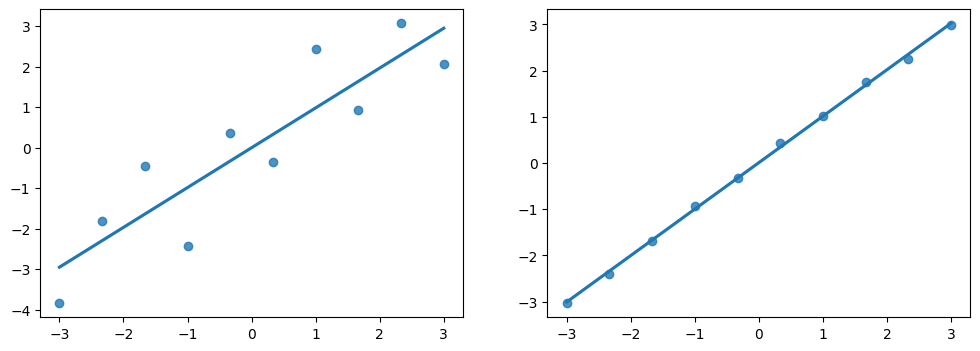

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
x_reg = np.linspace(-3, 3, 10)
NOISE_VARIANCE = 1
y_noise = x_reg + np.random.normal(0, NOISE_VARIANCE, 10)
LOW_NOISE_VARIANCE = 0.1
y_low_noise = x_reg + np.random.normal(0, LOW_NOISE_VARIANCE, 10)
sns.regplot(x=x_reg, y=y_noise, ax=ax1, ci=None)
sns.regplot(x=x_reg, y=y_low_noise, ax=ax2, ci=None)

Even though the data on the left is much more noisy, both linear regressions model the data with the sample simple line. There's no measure of uncertainty in the model, so let's try to add some.

What if (just for fun) we assumed $\beta_0$ and $\beta_1$ were normally distributed with variance equal to the variance in the data? Then our linear regression equation would look like this:

$$y = \Beta_0 + \Beta_1 x$$

where we've converted our betas to random variables as follows:

$$
\Beta_0 \sim \mathcal{N}(\beta_0, \sigma^2)
$$
$$
\Beta_1 \sim \mathcal{N}(\beta_1, \sigma^2)
$$

This reads "$\Beta_0$ is a random variable distributed according to a Gaussian with mean $\beta_0$ and variance $\sigma^2$".
We'll set $\sigma^2$ to be the variance of the data about the best fit line. Now that the betas are random variables, let's sample from them, and plot the resulting lines:

(Click the "New Sample" button below)

In [25]:
# Create scatter plot
beta_0 = 0
beta_1 = 1
beta_1_1 = np.corrcoef(x, y_noise)[0, 1] * np.std(y_noise) / np.std(x)
line_1 = x_reg * beta_1_1 + beta_0
line_2 = x_reg * beta_1 + beta_0
line_fig = go.Scatter(x=x, y=line_1, mode='lines')
fig =  go.FigureWidget(make_subplots(rows=1, cols=2, subplot_titles=('High Noise', 'Low Noise')))
fig.update_yaxes(range=[-5, 5], fixedrange=True)
fig.update_xaxes(range=[-3, 3], fixedrange=True)
scatter_fig = go.Scatter(x=x_reg, y=y_noise, mode='markers')
fig.add_trace(scatter_fig, row=1, col=1)
fig.add_trace(line_fig, row=1, col=1)
line_fig2 = go.Scatter(x=x_reg, y=line_2, mode='lines')
scatter_fig2 = go.Scatter(x=x_reg, y=y_low_noise, mode='markers')
fig.add_trace(scatter_fig2, row=1, col=2)
fig.add_trace(line_fig2, row=1, col=2)
fig.update_layout(showlegend=False)

# Define button and callback function
button = widgets.Button(description='New Sample', button_style='success')
clear_button = widgets.Button(description='Clear', button_style='danger')

def on_button_clicked(button):
    beta_0_rand = np.random.normal(beta_0, NOISE_VARIANCE, 1)
    beta_1_rand = np.random.normal(beta_1_1, NOISE_VARIANCE, 1)
    line_data = x_reg * beta_1_rand + beta_0_rand
    line_fig = go.Scatter(x=x_reg, y=line_data, mode='lines', opacity=.4)
    fig.add_trace(line_fig, row=1, col=1)
    beta_0_rand2 = np.random.normal(beta_0, LOW_NOISE_VARIANCE, 1)
    beta_1_rand2 = np.random.normal(beta_1, LOW_NOISE_VARIANCE, 1)
    line_data2 = x_reg * beta_1_rand2 + beta_0_rand2
    line_fig2 = go.Scatter(x=x_reg, y=line_data2, mode='lines', opacity=.4)
    fig.add_trace(line_fig2, row=1, col=2)

def on_clear(button_clear):
    fig.data = [] 
    scatter_fig = go.Scatter(x=x_reg, y=y_noise, mode='markers')
    fig.add_trace(scatter_fig, row=1, col=1)
    fig.add_trace(line_fig, row=1, col=1)
    fig.add_trace(scatter_fig2, row=1, col=2)
    fig.add_trace(line_fig2, row=1, col=2)
    
button.on_click(on_button_clicked)
clear_button.on_click(on_clear)
display(button)
display(clear_button)
display(fig)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2 and the array at index 1 has size 10

Each time you click the button, a new sample is drawn from the distribution of $\Beta_0$ and $\Beta_1$ (one for the noisy data and one for the less noisy), and the corresponding lines are plotted.

Notice what we've created: it's a distribution over _functions_. Each sample from  $y = \Beta_0 + \Beta_1 x$ is a different function. Also notice that as you sample more and more, the "spread" or uncertainty of the original fit becomes more and more apparent. You can also see that the uncertainty is higher in the noisier data.

> This framework is just to develop for intuition for distributions over functions. For a more rigorous take, check out the bayesian linear regression section [here](https://gaussianprocess.org/gpml/chapters/RW.pdf#page=26&zoom=100,240,358).

Returning to our original definition, we've checked off one core idea:

**GP Regression: A Multivariate Gaussian <span style="color:#0ff">Distribution over functions</span>, conditioned on some training data.**

What if we want to model a non-linear relationship? Now we're getting closer to the core idea of GPs. But of course, before we get to Gaussian processes, we have to talk about Gaussians.

# Gaussians...and Multivariate Gaussians!

The Gaussian, the bell curve, the normal distribution, we've seen it before. It's defined by 

$$
Y \sim \mathcal{N}(\mu, \sigma^2)
$$

> More precisely, the PDF of a Gaussian is given by:
>$$
>\mathcal{N}(\mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(y-\mu)^2}{2\sigma^2}\right)
>$$
> But no need to worry about this for now.

where $\mu$ is the mean and $\sigma^2$ is the variance. You can play around with the parameters of the distribution below. Each time you change the sliders, 10,000 samples are drawn from the distribution and plotted as a histogram.

In [26]:
# Create initial data for the histogram
x = np.random.normal(0, 1, size=10000)

# Create the histogram trace
hist_trace = go.Histogram(x=x, nbinsx=50)
fig_hist = go.FigureWidget(hist_trace)
fig_hist.update_xaxes(range=[-10, 10], fixedrange=True)

# Create the layout
layout = go.Layout(
    title='Normal Distribution Histogram',
    xaxis=dict(title='Value'),
    yaxis=dict(title='Count'),
)

# Define the function that will update the histogram
def update_histogram(mean, variance):
    x_new = np.random.normal(mean, variance, size=10000)
    with fig_hist.batch_update():
        fig_hist.data[0].x = x_new
        fig_hist.layout.title = f'Normal Distribution Histogram (µ={np.round(mean, 2)}, σ={np.round(variance, 2)})'


# Create the sliders
mean_slider = FloatSlider(value=0, min=-5, max=5, step=0.1, description='Mean:')
variance_slider = FloatSlider(value=1, min=0.1, max=5, step=0.1, description='Variance:')

# Create the interactive widget
interactive_histogram = interactive(update_histogram, mean=mean_slider, variance=variance_slider)

# Display the widget and the initial histogram
display(interactive_histogram)
display(fig_hist)

interactive(children=(FloatSlider(value=0.0, description='Mean:', max=5.0, min=-5.0), FloatSlider(value=1.0, d…

FigureWidget({
    'data': [{'nbinsx': 50,
              'type': 'histogram',
              'uid': '43872c42-a947-47cb-b32c-46f0cf020737',
              'x': array([ 1.33545641, -0.92730416,  0.80046569, ...,  0.55310363, -2.2491251 ,
                           0.37628505])}],
    'layout': {'template': '...',
               'title': {'text': 'Normal Distribution Histogram (µ=0.0, σ=1.0)'},
               'xaxis': {'fixedrange': True, 'range': [-10, 10]}}
})

What about multivariate Gaussians? That is, a Gaussian distribution but with more than one variable. They are basically the same thing, but instead of having a single mean and variance, there's there's a mean vector and a covariance matrix. 

So while a single Gaussian is this:

$$
Y \sim \mathcal{N}(\mu, \sigma^2)
$$

Where $\mu$ is the mean and $\sigma$ is the variance, a multivariate Gaussian is this:

$$
\textbf{Y} \sim \mathcal{N}(\boldsymbol{\mu}, \Sigma)
$$

Where $\boldsymbol{\mu}$ is a vector of means, $\Sigma$ is a covariance matrix.

$$
\boldsymbol{\mu} = \begin{bmatrix}
\mu_1 \\
\mu_2 \\
\vdots \\
\mu_n
\end{bmatrix},

\qquad
\Sigma = \begin{bmatrix}
\sigma_{11} & \sigma_{12} & \dots & \sigma_{1n} \\
\sigma_{21} & \sigma_{22} & \dots & \sigma_{2n} \\
\vdots & \vdots & \ddots & \vdots \\
\sigma_{n1} & \sigma_{n2} & \dots & \sigma_{nn}
\end{bmatrix}.
$$

In the above expressions, $\mu_i$ is the mean of the $i$ th component of $\textbf{Y}$

In this case when we sample from $\textbf{Y}$, we get a vector $\textbf{Y} = [Y_1, Y_2, \dots, Y_n]^T$,  instead of just a single value


Nothing too crazy right? The biggest difference is that the multivariate normal distribution has a covariance matrix. 

In the covariance matrix we specify not only the variance of each variable, but also the covariance between each variable and every other. So each of the $n$ variables in a multivariate Gaussian can be correlated with each other. Below is an overhead view of a bunch of samples for a 2D multivariate Gaussian distribution. You can interactively change the covariance matrix to see how it affects the distribution.

TODO: think more about positive semidefinite. Not simply positive an symmetric.

In [6]:
import warnings
warnings.filterwarnings("ignore")

def create_gaussian_plot(cov_matrix):
    x, y = np.random.multivariate_normal([0, 0], cov_matrix, 10000).T
    mv_fig = px.scatter(x=x, y=y, labels={"x": "Y1", "y": "Y2"}, opacity=0.1,
                        marginal_x='histogram', marginal_y='histogram'
                     )
    mv_fig.update_layout(title="2D Multivariate Gaussian Distribution")
    return mv_fig

# Step 6: Create the interactive table and plot
initial_cov_matrix = np.array([[1, 0], [0, 1]])
plotly_figure = go.FigureWidget(create_gaussian_plot(initial_cov_matrix))

cov_00 = FloatText(value=1, description="Cov(Y1, Y1)", step=.1)
cov_01 = FloatText(value=0, description="Cov(Y1, Y2)", step=.1)
cov_10 = FloatText(value=0, description="Cov(Y2, Y1)", step=.1)
cov_11 = FloatText(value=1, description="Cov(Y2, Y2)", step=.1)
valid = widgets.Valid(
    value=True,
)

# Step 5: Create the interactive update function
def update_gaussian_plot(cov_00, cov_01, cov_10, cov_11, plotly_figure=plotly_figure):
    if cov_01 != cov_10 or min(cov_00, cov_11) < 0:
        valid.value = False
        valid.description = "Covariance is not symmetric positive-semidefinite"
        valid.style = {'description_width': 'initial'} 
    else:
        valid.value = True
        valid.description = "" 
        cov_matrix = np.array([[cov_00, cov_01], [cov_10, cov_11]])
        mv_fig = create_gaussian_plot(cov_matrix)
        with plotly_figure.batch_update():
            plotly_figure.data[0]['y'] = mv_fig.data[0]['y']  # type: ignore 
            plotly_figure.data[0]['x'] = mv_fig.data[0]['x']  # type: ignore 

interactive_plot = interactive_output(
    update_gaussian_plot,
    {"cov_00": cov_00, "cov_01": cov_01, "cov_10": cov_10, "cov_11": cov_11},
)

# Step 7: Display the table and plot
ui = VBox([ HBox([widgets.HTMLMath(value=r"<br>Σ = "), HBox([ VBox([cov_00, cov_01]), VBox([cov_10, cov_11])])]), valid, plotly_figure])
display(ui, interactive_plot)

Output()

Note that if you change the diagonal elements, the variance of one or the other variable will change (look at the scale of axes). If you change the off-diagonal elements, the covariance between the two variables will change. 

You also probably saw that the matrix has to be symmetric and with positive diagonals. Why? Well think about what covariance is: its how two variables vary together. It doesn't make sense for Cov(X,Y) != Cov(Y,X). And it doesn't make sense for Cov(X,X) — that is, Var(X) — to be negative.

Also note that while the combined joint distribution changes form, each of the individual distributions is still a Gaussian. That is to say, the distribution of $X_1$ is still a gaussian, and the distribution of $X_2$ is still a Gaussian. The only thing that changes is the covariance between the two variables.

## Gaussian Distribution Over Functions

So far we've visualized a multivariate Gaussian of just two variables, but you can imagine taking this into many many dimensions. That is to say, many many Gaussian random variables that may or may not be correlated with each other according to some big covariance matrix.

In order to think about more than two dimensions, we'll need to visualize our distributions differently. Let's start with a 1-D Gaussian. We'll draw samples from the distribution and plot them below:

In [7]:
# Create scatter plot
scatter = go.Scatter(mode='markers')
layout = go.Layout(title='Samples from a 1-D Gaussian Distribution')
fig_1d = go.FigureWidget(go.Figure(data=[scatter], layout=layout) )

# Define button and callback function
button = widgets.Button(description='New Sample', button_style='success')
clear_button = widgets.Button(description='Clear', button_style='danger')

def on_button_clicked(button):
    x = ['1']
    y = np.random.normal(size=1)
    scatter = go.Scatter(x=x, y=y, mode='markers', name="Sample")
    fig_1d.add_trace(scatter)

def on_clear(button_clear):
    fig_1d.data = [] 
    
button.on_click(on_button_clicked)
clear_button.on_click(on_clear)
display(button)
display(clear_button)
display(fig_1d)


Button(button_style='success', description='New Sample', style=ButtonStyle())

Button(button_style='danger', description='Clear', style=ButtonStyle())

FigureWidget({
    'data': [{'mode': 'markers', 'type': 'scatter', 'uid': 'b305e33f-935e-41fb-b6d1-7bc5a8bea382'}],
    'layout': {'template': '...', 'title': {'text': 'Samples from a 1-D Gaussian Distribution'}}
})

Each new sample is drawn from a normal distribution with mean 0 and variance 1.

What if we want to sample from a multivariate normal distribution? Well, this time $\textbf{Y}$ is a _vector_ of random variables. If $\textbf{Y}$ is 2-d then $\textbf{Y} = [Y_1, Y_2]^T$, so each sample is a vector of two values which we'll plot each on their own part of the X-axis.

In [8]:
# Create scatter plot
x = ['1', '2']
scatter = go.Scatter(x = x)
layout = go.Layout(title='Samples from 2-D Multivariate Gaussian Distribution')
fig2 = go.FigureWidget(go.Figure(data=[scatter], layout=layout) )
fig2.data = [] 

# Define button and callback function
button = widgets.Button(description='New Sample', button_style='success')
clear_button = widgets.Button(description='Clear', button_style='danger')

def on_button_clicked(button):
    y = np.random.multivariate_normal(mean=[0, 0], cov=[[1,0], [0, 1]], size=1)[0]
    scatter = go.Scatter(x=x, y=y, mode='markers', name="Sample")
    fig2.add_trace(scatter, )


def on_clear(button_clear):
    fig2.data = [] 
    
button.on_click(on_button_clicked)
clear_button.on_click(on_clear)
display(button)
display(clear_button)
display(fig2)

Button(button_style='success', description='New Sample', style=ButtonStyle())

Button(button_style='danger', description='Clear', style=ButtonStyle())

FigureWidget({
    'data': [], 'layout': {'template': '...', 'title': {'text': 'Samples from 2-D Multivariate Gaussian Distribution'}}
})

So now each time we sample from a bivariate normal distrubtion, we get a vector of two numbers, which we plot as two connected points. Now let's look at a 3-D Gaussian,  $\textbf{Y}_{3D} = [Y_1, Y_2, Y_3]^T$, 

In [9]:
# Create scatter plot
scatter = go.Scatter(mode='markers')
layout = go.Layout(title='Samples from a 3-D Multivariate Gaussian Distribution')
fig3 = go.FigureWidget(go.Figure(data=[scatter], layout=layout) )

# Define button and callback function
button = widgets.Button(description='New Sample', button_style='success')
clear_button = widgets.Button(description='Clear', button_style='danger')

def on_button_clicked(button):
    x = ['1', '2', "3"]
    y = np.random.multivariate_normal(mean=[0, 0, 0 ], cov=[[1,0, 0], [0, 1, 0], [0,0,1]], size=1)[0]
    scatter = go.Scatter(x=x, y=y, mode='markers', name="Sample")
    fig3.add_trace(scatter, )


def on_clear(button_clear):
    fig3.data = [] 
    
button.on_click(on_button_clicked)
clear_button.on_click(on_clear)
display(button)
display(clear_button)
display(fig3)


Button(button_style='success', description='New Sample', style=ButtonStyle())

Button(button_style='danger', description='Clear', style=ButtonStyle())

FigureWidget({
    'data': [{'mode': 'markers', 'type': 'scatter', 'uid': 'db0f938c-e69b-4f68-a9a3-10cda76b9fe7'}],
    'layout': {'template': '...', 'title': {'text': 'Samples from a 3-D Multivariate Gaussian Distribution'}}
})

Now let's take it to an extreme: a 100-D Gaussian! $\textbf{Y}_{100D} = [Y_1, Y_2, Y_3, \dots, Y_{100}]^T$, so every sample is a vector of 100 random values.

In [10]:
# Create scatter plot
scatter = go.Scatter(mode='markers')
layout = go.Layout(title='Sample from a 100-D Multivariate Gaussian Distribution')
fig100 = go.FigureWidget(go.Figure(data=[scatter], layout=layout) )

# Define button and callback function
button = widgets.Button(description='New Sample', button_style='success')
clear_button = widgets.Button(description='Clear', button_style='danger')
connect_points = widgets.Button(description='Connect Points', button_style='success')

def on_button_clicked(button):
    x = np.linspace(0, 100, 100)
    y = np.random.multivariate_normal(mean=np.zeros(100), cov=np.identity(100), size=1)[0]
    scatter = go.Scatter(x=x, y=y, mode='markers', name="Sample")
    fig100.add_trace(scatter, )


def on_clear(button_clear):
    fig100.data = [] 

def on_connect(connect_points):
    for f in fig100.data:
        f['mode'] = 'lines+markers'

    
button.on_click(on_button_clicked)
clear_button.on_click(on_clear)
connect_points.on_click(on_connect)
display(button)
display(connect_points)
display(clear_button)
display(fig100)

Button(button_style='success', description='New Sample', style=ButtonStyle())

Button(button_style='success', description='Connect Points', style=ButtonStyle())

Button(button_style='danger', description='Clear', style=ButtonStyle())

FigureWidget({
    'data': [{'mode': 'markers', 'type': 'scatter', 'uid': '0d09aa40-5fd7-4cf8-b4e7-6cb366f3357e'}],
    'layout': {'template': '...', 'title': {'text': 'Sample from a 100-D Multivariate Gaussian Distribution'}}
})

Cool, so now we can visualize samples from a 100-D Gaussian in this kinda of weird way. How is this useful? And how does this relate to a Gaussian Process regression?

You'll notice the above plot has a "Connect points" button. If you click it, each variable in a given sample gets connected to the next. Try it out!

Do these connected samples remind you of anything? Maybe a certain class of elementary mathematical objects?

If you thought "functions" then you are getting what I'm going for here. Each sample from the 100-D Gaussian is starting to look like some curve where, for any x-coordinate (which is just the index of the vector output of the multivariate gaussian) you can look up a y-value. So this kinda-sorta function can be defined as 

$$
f(x) = Y_{x}
$$

given a multivariate Gaussian $Y = [Y_1, Y_2, Y_3, \dots, Y_{x}]^T \sim \mathcal{N}(\boldsymbol{\mu}, \Sigma)$.

But remember what each different colored curve is: it's a sample from a multivariate normal distribution. It's almost like the 100-D Gaussian specifies a _distribution over functions_...

<img src="./2023-04-18-11-13-04.png" width="200" height="200" />

_Almost_. The 100-D Gaussian really only specifies a distribution over 100 discrete values, so it's not quite a distribution over functions $f(x)$ that can take _any_ value of $x$. Hold that thought for now, we'll return to this later. 

But first you might have some questions. Remember, the above plot was made by taking a few samples from 100-D gaussian, $\textbf{Y}_{100D} \sim \mathcal{N}(\boldsymbol{\mu}, \Sigma)$

But I didn't tell you what $\boldsymbol{\mu}$ and $\Sigma$ were. Well, I actually used a mean vector of all zeros:

$$
\boldsymbol{\mu} =  \begin{bmatrix}
0 \\
0 \\
\vdots \\
0
\end{bmatrix},
$$

and for the covariance matrix I simply used the Identity matrix.

$$
\Sigma = \begin{bmatrix}
1 & 0 & \dots & 0 \\
0 & 1 & \dots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \dots & 1
\end{bmatrix}.
$$

Since this covariance matrix is really big, let's visualize it with a heatmap:

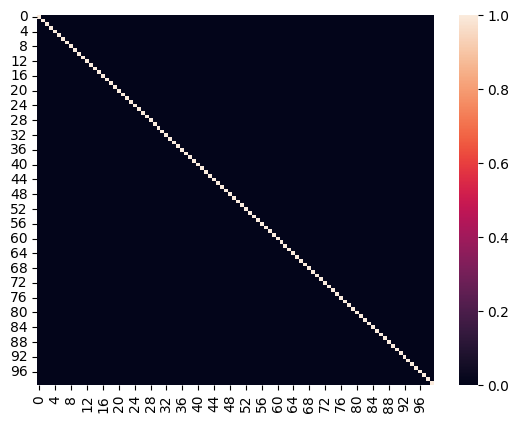

In [11]:
sns.heatmap(np.identity(100))
plt.show()

This means that each of the variables in our multivariate normal distribution are.....???? (hover over the text below to see the answer)

In [12]:
HTML('''
<span class="hover-text">Hover for answer</span>:

<span class="hidden-text">INDEPENDENT!</span>

<style>
  .hidden-text {
    display: none;
  }
  
  .hover-text:hover + .hidden-text {
    display: inline;
    font: 50px;
  }
</style>
''')


No variable has any covariance with any other, so you than think of this multivariate Gaussian as simply 100 separate Gaussians, each with mean = 0 and variance 1. This is why the curves we plotted above are so all over the place: each point is randomly bouncing up and down with no influence from its neighbors.

What if we add some non-zero values to the covariance matrix that are off-diagonal? 

>Remember the diagonal elements of the matrix at row and column $i$ is $Cov(Y_i, Y_i) = Var(Y_i)$ while the off-diagonal elements at $i,j$ are $Cov(Y_i, Y_j)$. 

For example, check out the covariance matrix below: 

In [13]:
def pairwise_rbf(xa, xb, sigma=5):
    sq_norm = (-0.5/sigma**2) * sp.spatial.distance.cdist(xa, xb, 'sqeuclidean')
    return np.exp(sq_norm)

<Axes: >

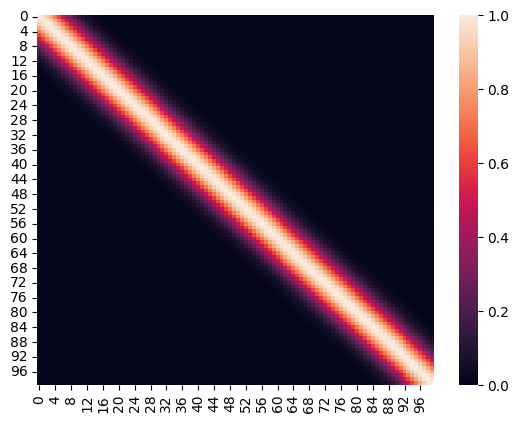

In [14]:
xa = np.arange(0, 100, 1).reshape(1, -1).T
xb = np.arange(0, 100, 1).reshape(1, -1).T
C = pd.DataFrame(pairwise_rbf(xa, xb))
sns.heatmap(C)

It looks very similar, but it's "fuzzier" around the diagonal. Think about what type of values you would expect from a Gaussian with this covariance matrix.

It's saying that variables near each other are more correlated than variables far away. For example variable 1 is more correlated with variable 2 than it is with variable 100. Let visualize some samples from a 100-d Gaussian with this new covariance matrix. But before you hit the "sample" button, what do you think these new curves will look like?

In [15]:
# Create scatter plot
scatter = go.Scatter(mode='markers')
layout = go.Layout(title='Samples from a 100-D Multivariate Gaussian with new covariance')
fig_rbf = go.FigureWidget(go.Figure(data=[scatter], layout=layout) )

# Define button and callback function
button = widgets.Button(description='New Sample', button_style='success')
clear_button = widgets.Button(description='Clear', button_style='danger')

def on_button_clicked(button):
    x = np.linspace(0, 100, 100)
    cov = pairwise_rbf(x.reshape(-1, 1), x.reshape(-1, 1))
    y = np.random.multivariate_normal(mean=np.zeros(100), cov=cov, size=1)[0]
    scatter = go.Scatter(x=x, y=y, mode='lines+markers')#, marker=dict(color=color))
    fig_rbf.add_trace(scatter, )


def on_clear(button_clear):
    fig_rbf.data = [] 
    
button.on_click(on_button_clicked)
clear_button.on_click(on_clear)
display(button)
display(clear_button)
display(fig_rbf)


Button(button_style='success', description='New Sample', style=ButtonStyle())

Button(button_style='danger', description='Clear', style=ButtonStyle())

FigureWidget({
    'data': [{'mode': 'markers', 'type': 'scatter', 'uid': '89b4cecf-9347-4061-b49d-963e0ffd534f'}],
    'layout': {'template': '...', 'title': {'text': 'Samples from a 100-D Multivariate Gaussian with new covariance'}}
})

Cool! They are now much smoother. This is because the variables near each other are more correlated, so nearby points are more likely to be similar. This smooths out the curves.

Now we can see that by changing the covariance matrix, we can control the shape of the functions that our multivariate normal distribution produces.

We've been using the word "functions" a lot now, but we still never really resolved the problem that these samples are really just 100-D vectors. Sure we can connect the points with littles lines, but that's not really the same as a function. How do we get a distribution over true functions?

The answer lies in how we define the covariance and mean of our multivariate Gaussian. So far we've been manually inputting some mean vector and covariance matrix. Since these are objects with discrete, finite elements, we can't really think of the distributions they define as functions. But what if we could redefine these objects (the mean and covariance) as functions? 

Mathematically:
$$
\boldsymbol{\mu} = m(\textbf{x}) \\
\Sigma = k(\textbf{x, x})
$$

Now for whatever $x$ we are interested in, we can sample from a multivariate Gaussian with mean $m(\textbf{x})$ and covariance $k(\textbf{x, x})$. This is one of those mathematical tricks that's so simple it's hard to understand, or maybe feels like cheating, so let's go through an example. 

Say we want to sample from a few specific real number $\textbf{x} = [-\pi, \pi, 2\pi]^T$ (some multiples of pi, as in 3.141...). First let's define a mean function $m(\textbf{x})$. We can use anything we like, so let's so something really simple: $m(\textbf{x}) = \textbf{x}$. 

For the covariance function $k(\textbf{x, x})$, we need a function of x that generates a symmetric matrix with a positive diagonal (otherwise it would not be a valid covariance). Again let's just do something really simple: $k(\textbf{x}, \textbf{x}) = \operatorname{diag}(\textbf{x} \odot \textbf{x} )$, where we take $\odot$ to mean the element-wise product of $\textbf{x}$ with $\textbf{x}$.

> You maybe be wondering, "why define the covariance function as $k(\textbf{x, x})$ instead of simply $k(\textbf{x})$?". The reason is that covariance functions in general calculate a covariance between two vectors that are not necessarily the same. Here we are just calculating the covariance of $\textbf{x}$ with itself, but this will not always be the case...

So if we put out test vector into these functions we get:

$$
\boldsymbol{\mu} = m(\textbf{x}) = \textbf{x} = [-\pi, \pi, 2\pi]^T\\
$$
$$
\Sigma = k(\textbf{x}, \textbf{x}) = \operatorname{diag}(\textbf{x}\odot\textbf{x}) = \begin{bmatrix}
(-\pi)^2 & 0 & 0 \\
0 & (\pi)^2 & 0 \\
0 & 0 & (2\pi)^2
\end{bmatrix}
$$

Now we can sample from a multivariate Gaussian at these specific values of $x$:

In [16]:
x_specific = np.array([-np.pi, np.pi, 2*np.pi])
m = lambda x: x
k = lambda x: np.diag(x**2)
# Create scatter plot
scatter = go.Scatter(mode='markers')
layout = go.Layout(title='Samples from a 3-D Multivariate Gaussian a specific places')
fig_real = go.FigureWidget(go.Figure(data=[scatter], layout=layout) )

# Define button and callback function
button = widgets.Button(description='New Sample', button_style='success')
clear_button = widgets.Button(description='Clear', button_style='danger')

def on_button_clicked(button):
    cov = k(x_specific) 
    mean = m(x_specific)
    y = np.random.multivariate_normal(mean=mean, cov=cov, size=1)[0]
    scatter = go.Scatter(x=x_specific, y=y, mode='lines+markers', name="Sample")
    fig_real.add_trace(scatter)


def on_clear(button_clear):
    fig_real.data = [] 
    
button.on_click(on_button_clicked)
clear_button.on_click(on_clear)
display(button)
display(clear_button)
display(fig_real)

Button(button_style='success', description='New Sample', style=ButtonStyle())

Button(button_style='danger', description='Clear', style=ButtonStyle())

FigureWidget({
    'data': [{'mode': 'markers', 'type': 'scatter', 'uid': '9918698b-cad4-42c7-8d71-f183be32e760'}],
    'layout': {'template': '...', 'title': {'text': 'Samples from a 3-D Multivariate Gaussian a specific places'}}
})

But now that we've defined our mean and covariance functions, we can sample from a multivariate Gaussian at any value of $x$ we want. For example, let's sample at 100 evenly spaced real values of $x$ between -1 and 1. All we do is plug these values into our mean and covariance functions, and then sample from the resulting multivariate Gaussian.

In [27]:
x_real_big = np.linspace(-1, 1, 100) 
m = lambda x: x
k = lambda x: np.diag(x**2)
# Create scatter plot
scatter = go.Scatter(mode='markers')
layout = go.Layout(title='Samples from a 100-D Multivariate Gaussian a specific places')
fig_real_big = go.FigureWidget(go.Figure(data=[scatter], layout=layout) )

# Define button and callback function
button = widgets.Button(description='New Sample', button_style='success')
clear_button = widgets.Button(description='Clear', button_style='danger')

def on_button_clicked(button):
    cov = k(x_real_big) 
    mean = m(x_real_big)
    y = np.random.multivariate_normal(mean=mean, cov=cov, size=1)[0]
    scatter = go.Scatter(x=x_real_big, y=y, mode='lines+markers')#, marker=dict(color=color))
    fig_real_big.add_trace(scatter)


def on_clear(button_clear):
    fig_real_big.data = [] 
    
button.on_click(on_button_clicked)
clear_button.on_click(on_clear)
display(button)
display(clear_button)
display(fig_real_big)


Button(button_style='success', description='New Sample', style=ButtonStyle())

Button(button_style='danger', description='Clear', style=ButtonStyle())

FigureWidget({
    'data': [{'mode': 'markers', 'type': 'scatter', 'uid': '7c9ba5d0-ef43-49ec-95ef-ed84d45d6901'}],
    'layout': {'template': '...', 'title': {'text': 'Samples from a 100-D Multivariate Gaussian a specific places'}}
})

Now we've truly got a distribution over functions!

If we want the distribution at _any_ value $x$, we can just plug it in to the mean and covariance functions and voila! We just need to define a mean and valid covariance function that we like, and we can sample from a multivariate Gaussian at any value of $x$ we want. 

By the way, "covariance functions" are usually referred to by a fancy name: **kernel functions**. Remember this plot of a covariance matrix from earlier?

<Axes: >

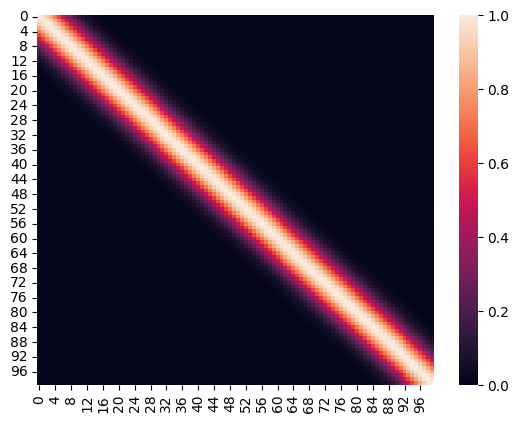

In [18]:
xa = np.arange(0, 100, 1).reshape(1, -1).T
C = pd.DataFrame(pairwise_rbf(xa, xa))
sns.heatmap(C)

This covariance we actually generated by using a specific kernel function called the squared exponential kernel, a.k.a. the Gaussian kernel a.k.a the RBF kernel. 

It's defined as:	

$$
k(\textbf{x}) = \exp\left(-\frac{1}{2l^2} ||\textbf{x} - \textbf{x}||^2\right)
$$

where $||\textbf{x} - \textbf{x}||^2$ is the element-wise squared difference matrix between each element of $x$ with each other element, and $l$ is an adjustable parameter. 

No need to worry about the math here too closely. The important thing to note is that the squared exponential kernel is a function of $\textbf{x}$ that generates a positive semidefinite matrix. It's covariance function, a.k.a. kernel, and it happens to be one of the most useful kernels in the real-world.

Using this kernel function, lets sample from a multivariate Gaussian at 100 evenly spaced real values of $x$ between -10 and 10. But this time you can adjust the slider to change the value of the kernel's $l$ parameter and see how it changes the shape of the covariance matrix and the resulting distribution over functions.

In [19]:
layout = go.Layout(title='Samples from a 100-D Multivariate Gaussian with new covariance')
fig_double = go.FigureWidget(make_subplots(rows=1, cols=2, subplot_titles=('Function Samples', 'Covariance Matrix')))
xa = np.linspace(-10, 10, 100).reshape(1, -1).T
C = pd.DataFrame(pairwise_rbf(xa, xa))
cov_map = go.Heatmap(z=np.rot90(C), showscale=False)
fig_double.add_trace(cov_map, row=1, col=2)

# Define button and callback function
button = widgets.Button(description='New Sample', button_style='success')
clear_button = widgets.Button(description='Clear', button_style='danger')
length_slider = FloatSlider(value=5, min=.1, max=10, step=0.1, description='Kernel Parameter l:')
length_slider.style = {'description_width': 'initial'} 

def on_button_clicked(button):
    global C
    x = np.linspace(-10, 10, 100)
    y = np.random.multivariate_normal(mean=np.zeros(100), cov=C, size=1)[0]
    scatter = go.Scatter(x=x, y=y, mode='lines', name=f'Kernel l = {np.round(length_slider.value, 2)}')
    fig_double.add_trace(scatter, row=1, col=1)

def on_clear(button_clear):
    #delete all traces in the subplot
    fig_double.data = fig.data[:1]

def update_covariance(length_scale):
    global C
    cov = pairwise_rbf(xa, xa, sigma=length_scale['new'])
    C = pd.DataFrame(cov)
    s = fig_double.data[0]
    s.z = np.rot90(C)

length_slider.observe(update_covariance, names='value')  # type: ignore 
button.on_click(on_button_clicked)
clear_button.on_click(on_clear)
display(button)
display(clear_button)
display(length_slider)
display(fig_double)

Button(button_style='success', description='New Sample', style=ButtonStyle())

Button(button_style='danger', description='Clear', style=ButtonStyle())

FloatSlider(value=5.0, description='Kernel Parameter l:', max=10.0, min=0.1, style=SliderStyle(description_wid…

FigureWidget({
    'data': [{'showscale': False,
              'type': 'heatmap',
              'uid': 'ef8d8b63-8d49-415e-9762-956be3b5b7de',
              'xaxis': 'x2',
              'yaxis': 'y2',
              'z': array([[3.35462628e-04, 3.93984070e-04, 4.61959816e-04, ..., 9.96740351e-01,
                           9.99184090e-01, 1.00000000e+00],
                          [3.93984070e-04, 4.61959816e-04, 5.40780169e-04, ..., 9.99184090e-01,
                           1.00000000e+00, 9.99184090e-01],
                          [4.61959816e-04, 5.40780169e-04, 6.32016381e-04, ..., 1.00000000e+00,
                           9.99184090e-01, 9.96740351e-01],
                          ...,
                          [9.96740351e-01, 9.99184090e-01, 1.00000000e+00, ..., 6.32016381e-04,
                           5.40780169e-04, 4.61959816e-04],
                          [9.99184090e-01, 1.00000000e+00, 9.99184090e-01, ..., 5.40780169e-04,
                           4.61959816e-04, 3.939

## Conditioning on Data

Wow, we've come a long way. Let's regroup here and remember our original definition of a Gaussian Process Regression.

**GP Regression: <span style="color:#0ff">A Multivariate Gaussian Distribution over functions</span>, conditioned on some training data.**

We're more than half-way done! But we still need to condition it on some training data. Right now we're just sampling these pretty functions, but they are completely random. 

Conditioning means we want the probability of some outcome given some data. Mathematically we write this as:

$$
p(y | x)
$$

that is, the probability of some outcome $y$ given some other data $x$. 

Let's take a simple toy problem as a concrete example:

Say we are trying to predict the cost of a house along a particular road. At one end of the road, there is a nuclear power plant (yikes!). We have some data on the cost of some of the houses on this road, but we want to predict the cost of a house at any location. Let's look at the data first: 

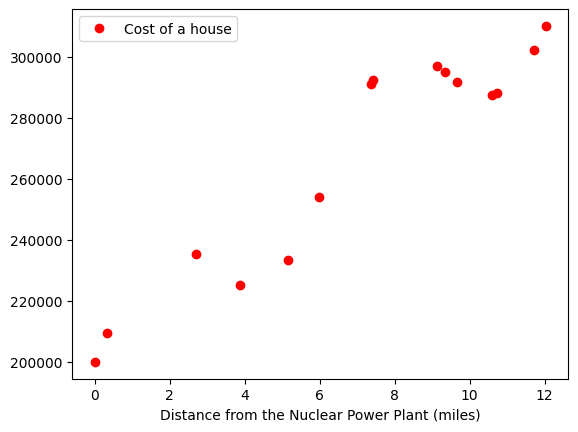

In [20]:
X = np.array([[9.34825241e+00],
       [9.67438030e+00],
       [1.17250505e+01],
       [5.99427279e+00],
       [1.07375146e+01],
       [3.87950162e+00],
       [2.71045131e+00],
       [7.35740185e+00],
       [9.13638194e+00],
       [1.05863164e+01],
       [7.42074188e+00],
       [1.20328572e+01],
       [5.15531137e+00],
       [3.24806136e-01],
       [1.32962952e-03]])
y = np.array([[295011.54177245],
       [291803.4301587 ],
       [302340.03191297],
       [254244.52812629],
       [288037.40660445],
       [225340.17067212],
       [235462.67258466],
       [291158.36183822],
       [297052.11645609],
       [287514.83630223],
       [292359.62730391],
       [310157.34073017],
       [233483.05286424],
       [209630.56264745],
       [200039.88887763]])
DOMAIN = (0, 4*np.pi)
X_axis = np.linspace(DOMAIN[0], DOMAIN[1], 100).reshape(1, -1).T
y_true = (.1 * np.sin(X_axis) + 1) * 200000 + X_axis * 10000
# X = np.random.uniform(DOMAIN[0], DOMAIN[1], 15).reshape(1, -1).T
# y = (.1 * np.sin(X) + 1) * 200000 + X * 10000
X_test = np.linspace(DOMAIN[0], DOMAIN[1], 100).reshape(1, -1).T
df = pd.DataFrame(y.flatten(), index=X.flatten(), columns=["Cost of a house"]).sort_index()
df.index.name = "Distance from the Nuclear Power Plant (miles)"
df_ax = df.plot(style="o", color="red" )
# pd.DataFrame(y_true.flatten(), index=X_axis.flatten(), columns=["y true"]).sort_index().plot(ax=df_ax, color="black" )

Right away we see a couple things. Housing costs are not just linearly increasing as we get further away from the plant; there seem to be a few dips. Maybe there is a prison 5 miles away from the plant; who knows. Regardless, we probably want some non-linear model for this data. 

The main question at hand is given this known cost data, what is the expected cost of a house at another location $x$?

To state this mathematically, we want some function structured as follows:

$$
p(\textbf{c} | \textbf{x})
$$

That is, we want the probability distribution of cost of a house $c$, given its distance $x$ from the nuclear plant. Since we've been thinking about multivariate Gaussian, let's make an assumption that the distribution above follows a multivariate Gaussian.

$$
p(\textbf{c} | \textbf{x}) \sim \mathcal{N}(m(\textbf{x}), k(\textbf{x}, \textbf{x}))
$$

Where $k(\textbf{x}, \textbf{x})$ is the covariance function, and $m(\textbf{x})$ is the mean function. For now we'll just assume that the mean function is zero, and for the covariance function we'll use the squared exponential kernel. 

Why these? Remember that the squared exponential function's effect above: it sort of "smooths" out the data. This makes sense to model housing prices, because it's reasonable to expect that houses near each other will have similar prices. 

> But why is the mean function zero? A: trust me bro. It just works out in practice that the covariance function is enough to model the data. For example sklearn's GP implementation doesn't even let you specify a mean function.

We really need the following if we want to condition on the known data:

$$
p(\textbf{c} | \textbf{x}, \textbf{c}_{\text{known}}, \textbf{x}_{\text{known}})
$$

Putting this into words, we want the probability distribution of prices of a house, given its location _and_ given the prices of houses at some other locations.

Let's assume that the known data also came from the same multivariate Gaussian distribution as the unknown. So we can write:


$$
p(\textbf{c}_{\text{known}}| \textbf{x}_{\text{known}}) \sim \mathcal{N}(0, k(\textbf{x}_{\text{known}}, \textbf{x}_{\text{known}}))
$$

And for the unknown data, remember we had:

$$
p(\textbf{c} | \textbf{x}) \sim \mathcal{N}(0, k(\textbf{x}, \textbf{x}))
$$

Notice that we've assumed both the known data and the unknown data come from multivariate Gaussians. What if we just combined them into one big multivariate gaussian? We could basically just stack the distributions on top of each other to form a big "mother" Gaussian.

$$
p(\begin{bmatrix} \textbf{c} \\ \textbf{c}_{\text{known}} \end{bmatrix} | \begin{bmatrix} \textbf{x} \\ \textbf{x}_{\text{known}} \end{bmatrix}) \sim \mathcal{N}\left(\begin{bmatrix}0 \\ 0\end{bmatrix}, \begin{bmatrix}k(\textbf{x}, \textbf{x}) & k(\textbf{x}, \textbf{x}_{\text{known}}) \\ k(\textbf{x}_{\text{known}}, \textbf{x}) & k(\textbf{x}_{\text{known} }, \textbf{x}_{\text{known}})\end{bmatrix}\right)
$$

The one wrinkle here is the covariance function. For the off-diagonal elements, we need to use the covariance function between the unknown data and the known data. So _now_ we see why the kernel function is written as $k(\textbf{x}, \textbf{x})$; in this case we need to compute the covariance between two different vectors of data to fill in the off-diagonal blocks of the covariance matrix above.

Now question is can we massage the beast above into a probability distribution conditioned on the known data? Like so:

$p(\textbf{c} | \textbf{x}, \textbf{c}_{\text{known}}, \textbf{x}_{\text{known}}) \sim ???$

The answer is yes. It's the following:

$$
p(\textbf{c} | \textbf{x}, \textbf{c}_{\text{known}}, \textbf{x}_{\text{known}}) \sim \mathcal{N}\left(m(\textbf{x}) + k(\textbf{x}, \textbf{x}_{\text{known}})k(\textbf{x}_{\text{known}})^{-1}(\textbf{c}_{\text{known}} - m(\textbf{x}_{\text{known}})), k(\textbf{x}) - k(\textbf{x}, \textbf{x}_{\text{known}})k(\textbf{x}_{\text{known}})^{-1}k(\textbf{x}_{\text{known}}, \textbf{x})\right)
$$

Please don't get mad at me for just giving you the answer. It's a kind of complicated derivation, and I don't want us to get bogged down. If you want to go through it, see this section of [Gaussian Processes for Machine Learning](http://gaussianprocess.org/gpml/chapters/RW.pdf#page=218&zoom=100,240,358). 

For now, just accept that there's a nice closed form solution to this problem. 

Wait, uh, so we're done? 

**GP Regression: <span style="color:#0ff">A Multivariate Gaussian Distribution over functions, conditioned on some training data.</span>**

We're done! We've got a nice closed form distribution over functions conditioned on some data.

## Actually Fitting a Regression Model

Using our conditional distribution above, we can plug in our known house costs to create a conditional distribution of functions. Then we can sample from this distribution at, say, 100 evenly spaced distance from 0 to 12 miles away from the nuclear plant.

We have 15 know cost data points. This means that $\textbf{c}_{\text{known}}$ and $\textbf{x}_{\text{known}}$ is are vectors of length 15. We want to predicted prices at 100 evenly spaced points, so $\textbf{x}$ and $\textbf{c}$ are vectors of length 100. 

Plugging this into the conditional distribution above, we can now sample from the conditional distribution of functions:

In [21]:
def gp_posterior(y_train, X_train, X_test, sigma=1.):
    sigma_11 = pairwise_rbf(X_train, X_train, sigma=sigma)
    sigma_21 = pairwise_rbf(X_train, X_test, sigma=sigma).T
    sigma_22 = pairwise_rbf(X_test, X_test, sigma=sigma)
    sigma_12 = sigma_21.T 
    mu_2_1 = (sigma_21 @ sp.linalg.inv(sigma_11) @ y_train).flatten()
    sigma_2_1 = sigma_22 - sigma_21 @ sp.linalg.inv(sigma_11) @ sigma_12
    return mu_2_1, sigma_2_1

In [22]:
y_norm  = (y - y.mean()) / y.std()
mu, sigma = gp_posterior(y_norm, X , X_test, sigma=1)    

# Create scatter plot
scatter_init = go.Scatter(x=X.T[0], y=y.T[0], mode='markers', marker=dict(color='red', size=12), name='Known Data')
layout = go.Layout(title='Samples from a Gaussian Process conditioned on Known Housing Data', xaxis_title='Distance from the Nuclear Power Plant (miles)', yaxis_title='Cost of a house ($)')
fig_final = go.FigureWidget(go.Figure(data=[scatter_init], layout=layout) )
# Define button and callback function
button = widgets.Button(description='New Sample', button_style='success')
clear_button = widgets.Button(description='Clear', button_style='danger')

def on_button_clicked(button):
    y_hat = (np.random.multivariate_normal(mu, sigma, size=1) * y.std()) + y.mean()
    scatter = go.Scatter(x=X_axis.T[0], y=y_hat[0], mode='lines+markers', name=f'New Sample', marker=dict(size=4))
    fig_final.add_trace(scatter)

def on_clear(button_clear):
    fig_final.data = [] 
    
button.on_click(on_button_clicked)
clear_button.on_click(on_clear)
display(button)
display(clear_button)
display(fig_final)

Button(button_style='success', description='New Sample', style=ButtonStyle())

Button(button_style='danger', description='Clear', style=ButtonStyle())

FigureWidget({
    'data': [{'marker': {'color': 'red', 'size': 12},
              'mode': 'markers',
              'name': 'Known Data',
              'type': 'scatter',
              'uid': '9d6efcba-3f01-48fe-b9b3-3e86b5b3e9a3',
              'x': array([9.34825241e+00, 9.67438030e+00, 1.17250505e+01, 5.99427279e+00,
                          1.07375146e+01, 3.87950162e+00, 2.71045131e+00, 7.35740185e+00,
                          9.13638194e+00, 1.05863164e+01, 7.42074188e+00, 1.20328572e+01,
                          5.15531137e+00, 3.24806136e-01, 1.32962952e-03]),
              'y': array([295011.54177245, 291803.4301587 , 302340.03191297, 254244.52812629,
                          288037.40660445, 225340.17067212, 235462.67258466, 291158.36183822,
                          297052.11645609, 287514.83630223, 292359.62730391, 310157.34073017,
                          233483.05286424, 209630.56264745, 200039.88887763])}],
    'layout': {'template': '...',
               'title': {

Heck yeah! This looks like a Gaussian process regression! Clearly the samples from the distribution are conditioned on known data, because all the functions we sample pass through the known data points. But in between the known data points the functions are free to somewhat randomly vary, giving us an idea of the uncertainty. How smoothly the functions vary is determined by the covariance function, which in this case is the squared exponential kernel.

In the plot below, I've taken 1000 samples from this conditioned distribution (a.k.a. "posterior predictive distribution") and plotted them. I also plotted the real function that I used to generate the fake housing data in black. 

<Axes: xlabel='Blocks away from the Nuclear Power Plant', ylabel='Price'>

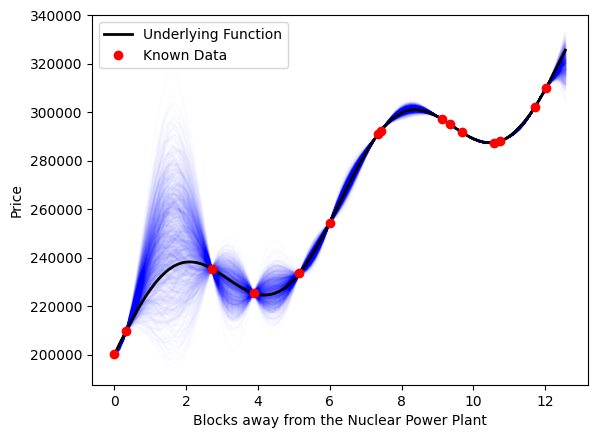

In [23]:
y_norm  = (y - y.mean()) / y.std()
mu, sigma = gp_posterior(y_norm, X , X_test, sigma=1)    
y_hat = (np.random.multivariate_normal(mu, sigma, size=1000) * y.std()) + y.mean()

df_1 = pd.DataFrame(y_hat.T, index=X_test.flatten()).sort_index().plot(alpha=.01, legend=False, color="blue")
df_1.set_ylabel("Price")
df_1.set_xlabel("Blocks away from the Nuclear Power Plant")
pd.DataFrame(y_true.flatten(), index=X_axis.flatten(), columns=["Underlying Function"]).sort_index().plot(ax=df_1, color="black", linewidth=2 )
pd.DataFrame(y.flatten(), index=X.flatten(), columns=["Known Data"]).sort_index().plot(ax=df_1, style="o", color="red" )

## Outro

You should now have the core ideas of Gaussian processes regression. If you still have some questions, like "how do we choose a kernel function?" or "how do we choose the best parameters for the kernel function?" or "do you really have to sample 1000 functions to get the confidence intervals?" then you should check out the resources below. They should be easy to understand now that you have the basics 

## References/Citations

- https://peterroelants.github.io/posts/gaussian-process-tutorial/
  - Really awesome set of blog posts that teaches GPs using Python. I basically took this post and made it more verbose. 
  - The other posts in the series go into more detail about the process of fitting a GP and optimizing the kernel and hyperparameters. 
- https://distill.pub/2019/visual-exploration-gaussian-processes/
  - Another good GP blog post with beautiful interactive visualizations: 
- https://www.dominodatalab.com/blog/fitting-gaussian-process-models-python
  - A good guide on using existing python libraries (lik scikit-learn) to fit GPs 
- http://gaussianprocess.org/gpml/chapters/
  - _The book_ on GPs, with probably all the detail you'll ever need: 